In [1]:
import meep as mp
import meep.adjoint as mpa
from meep import Animate2D
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from meep.materials import Ag
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
import matplotlib.colors as mcolors

mp.verbosity(1)
TiO2 = mp.Medium(index=2.6)
SiO2 = mp.Medium(index=1.44)
Si   = mp.Medium(index=3.4)
Air  = mp.Medium(index=1)

In [2]:
os.makedirs('DFT_empty',exist_ok=True) # Create Folder

In [4]:
monitor_position   = mp.Vector3(0, 0, 0)       # Focus position
monitor_size       = mp.Vector3(0.01,0.01,design_region_z_height)     # Focus Size//////0.11
FourierFields_x    = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ex,yee_grid=True)
FourierFields_y    = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ey,yee_grid=True)
FourierFields_z    = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ez,yee_grid=True)
ob_list            = [FourierFields_x,FourierFields_y,FourierFields_z]


def J(fields_x,fields_y,fields_z):
    ET_x = 0
    ET_y = 0
    ET_z = 0
    ET_x_length = fields_x.shape[1]
    ET_y_length = fields_y.shape[1]
    ET_z_length = fields_z.shape[1]
    for k in range(0,ET_x_length):
        ET_x = ET_x + npa.abs(fields_x[:,k]) ** 2
    for k in range(0,ET_y_length):
        ET_y = ET_y + npa.abs(fields_y[:,k]) ** 2
    for k in range(0,ET_z_length):
        ET_z = ET_z + npa.abs(fields_z[:,k]) ** 2
    ET = ( (npa.mean(ET_x)) + (npa.mean(ET_y)) + (npa.mean(ET_z)) ) ** (1/2)  
    return ET


opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    decimation_factor = 1 ,           # KEY BUG!!
    maximum_run_time=50,
)

In [5]:
evaluation_history = np.load('Post_evaluation_history.npy')
beta_A  = np.load("Post_beta_scale_array.npy")
eta_A   = np.load("Post_eta_i_array.npy")
cur_A   = np.load("Post_cur_beta_array.npy")
x_A     = np.load("Post_x_array.npy")

Text(0, 0.5, 'FOM')

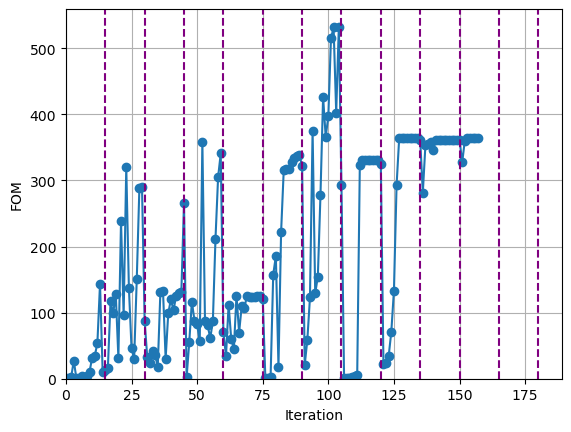

In [6]:
plt.figure()
plt.plot(evaluation_history, "o-")

for i in range(1,13):
    plt.axvline(x=15*i, color='purple', linestyle='--', label='x=3')
plt.grid(True)
plt.xlim(0)
plt.ylim(0)
plt.xlabel("Iteration")
plt.ylabel("FOM")

     block, center = (0,0,0)
          size (1,1,0.02)
          axes (1,0,0), (0,1,0), (0,0,1)


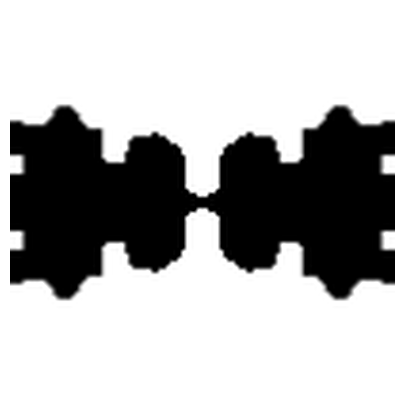

In [7]:
opt.update_design([mapping(x_A, eta_A, cur_A/beta_A)])  # cur_beta/beta_scale is the final beta in the optimization.
plt.figure(figsize=(5,5))
ax = plt.gca()
opt.plot2D(
    False,
    ax=ax,
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
    output_plane = mp.Volume(center=mp.Vector3(0,0,0), size=mp.Vector3(design_region_x_width, design_region_y_height, 0))
)
circ = Circle((2, 2), minimum_length / 2)
ax.add_patch(circ)
ax.axis("off")
plt.show()
plt.close()

In [8]:
opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy ,Sz),
    boundary_layers=pml_layers,
    geometry=[],
    sources=source,
    default_material=Air,
    resolution=resolution,
    k_point=kpoint,
    #symmetries=[mp.Mirror(direction=mp.X)],
    extra_materials = [Ag],
)
#src = mp.ContinuousSource(frequency=frequencies[0], fwidth=0.01 ,is_integrated=True)
src = mp.ContinuousSource(frequency=frequencies[0],is_integrated=True)
source = [mp.Source(src, component=mp.Ey, size=source_size, center=source_center)]
opt.sim.change_sources(source)

dft_fields_xz = opt.sim.add_dft_fields([mp.Ex,mp.Ey,mp.Ez],
                                fcen,0,1,
                                center=mp.Vector3(),
                                size=mp.Vector3(Sx,0,Sz-2 * pml_size),
                                yee_grid=False
                                )

dft_fields_yz = opt.sim.add_dft_fields([mp.Ex,mp.Ey,mp.Ez],
                                fcen,0,1,
                                center=mp.Vector3(),
                                size=mp.Vector3(0,Sy,Sz-2 * pml_size),
                                yee_grid=False
                                )

dft_fields_xyz12 = opt.sim.add_dft_fields([mp.Ex,mp.Ey,mp.Ez],
                                fcen,0,1,
                                center=mp.Vector3(0,0,0.01),
                                size=mp.Vector3(Sx,Sy,0),
                                yee_grid=False
                                )

dft_fields_xyz00 = opt.sim.add_dft_fields([mp.Ex,mp.Ey,mp.Ez],
                                fcen,0,1,
                                center=mp.Vector3(0,0,0),
                                size=mp.Vector3(Sx,Sy,0),
                                yee_grid=False 
                                )

dft_fields_x0yz0 = opt.sim.add_dft_fields([mp.Ex,mp.Ey,mp.Ez],
                                fcen,0,1,
                                center=mp.Vector3(0,0,0.01),
                                size=mp.Vector3(0,Sy,0),
                                yee_grid=False
                                )


opt.sim.run(until = 10)


-----------
Initializing structure...
time for choose_chunkdivision = 8.89301e-05 s
Working in 3D dimensions.
Computational cell is 1 x 1 x 2.62 with resolution 100
time for set_epsilon = 3.77704 s
lorentzian susceptibility: frequency=16.365, gamma=1.95106
lorentzian susceptibility: frequency=7.32593, gamma=0.738804
lorentzian susceptibility: frequency=6.60165, gamma=0.052426
lorentzian susceptibility: frequency=3.61417, gamma=0.364563
lorentzian susceptibility: frequency=0.658148, gamma=3.13427
drude susceptibility: frequency=1e-10, gamma=0.0387146
-----------


FloatProgress(value=0.0, description='0% done ', max=10.0)

Meep progress: 0.215/10.0 = 2.1% done in 4.0s, 182.9s to go
on time step 43 (time=0.215), 0.093372 s/step
Meep progress: 0.6/10.0 = 6.0% done in 8.1s, 126.4s to go
on time step 120 (time=0.6), 0.0525616 s/step
Meep progress: 0.98/10.0 = 9.8% done in 12.1s, 111.5s to go
on time step 196 (time=0.98), 0.0532783 s/step
Meep progress: 1.345/10.0 = 13.4% done in 16.2s, 104.0s to go
on time step 269 (time=1.345), 0.0554035 s/step
Meep progress: 1.73/10.0 = 17.3% done in 20.2s, 96.6s to go
on time step 346 (time=1.73), 0.0524672 s/step
Meep progress: 2.115/10.0 = 21.2% done in 24.2s, 90.3s to go
on time step 423 (time=2.115), 0.0520259 s/step
Meep progress: 2.485/10.0 = 24.8% done in 28.2s, 85.4s to go
on time step 497 (time=2.485), 0.0541898 s/step
Meep progress: 2.875/10.0 = 28.8% done in 32.3s, 80.0s to go
on time step 575 (time=2.875), 0.0518992 s/step
Meep progress: 3.265/10.0 = 32.6% done in 36.3s, 74.9s to go
on time step 653 (time=3.265), 0.0517982 s/step
Meep progress: 3.65/10.0 = 36.

In [9]:
Ex_xz = opt.sim.get_dft_array(dft_fields_xz,mp.Ex,0)
Ey_xz = opt.sim.get_dft_array(dft_fields_xz,mp.Ey,0)
Ez_xz = opt.sim.get_dft_array(dft_fields_xz,mp.Ez,0)
np.save('DFT_empty/Dft_empty_Ex_xz.npy',Ex_xz)
np.save('DFT_empty/Dft_empty_Ey_xz.npy',Ey_xz)
np.save('DFT_empty/Dft_empty_Ez_xz.npy',Ez_xz)

Ex_yz = opt.sim.get_dft_array(dft_fields_yz,mp.Ex,0)
Ey_yz = opt.sim.get_dft_array(dft_fields_yz,mp.Ey,0)
Ez_yz = opt.sim.get_dft_array(dft_fields_yz,mp.Ez,0)
np.save('DFT_empty/Dft_empty_Ex_yz.npy',Ex_yz)
np.save('DFT_empty/Dft_empty_Ey_yz.npy',Ey_yz)
np.save('DFT_empty/Dft_empty_Ez_yz.npy',Ez_yz)

Ex01 = opt.sim.get_dft_array(dft_fields_xyz12,mp.Ex,0)
Ey01 = opt.sim.get_dft_array(dft_fields_xyz12,mp.Ey,0)
Ez01 = opt.sim.get_dft_array(dft_fields_xyz12,mp.Ez,0)
np.save('DFT_empty/Dft_empty_Ex_xyz1.npy',Ex01)
np.save('DFT_empty/Dft_empty_Ey_xyz1.npy',Ey01)
np.save('DFT_empty/Dft_empty_Ez_xyz1.npy',Ez01)

Ex00 = opt.sim.get_dft_array(dft_fields_xyz00,mp.Ex,0)
Ey00 = opt.sim.get_dft_array(dft_fields_xyz00,mp.Ey,0)
Ez00 = opt.sim.get_dft_array(dft_fields_xyz00,mp.Ez,0)
np.save('DFT_empty/Dft_empty_Ex_xyz0.npy',Ex00)
np.save('DFT_empty/Dft_empty_Ey_xyz0.npy',Ey00)
np.save('DFT_empty/Dft_empty_Ez_xyz0.npy',Ez00)